In [18]:
# Import the necessary libraries first
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import chi2,r_regression
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_percentage_error
import yfinance as yf
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM,Dropout, BatchNormalization, Dense, Conv1D, MaxPool1D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
from keras.optimizer_v2.adam import Adam

In [2]:
# Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
data = yf.download('0700.hk')
data.drop("Adj Close",axis=1,inplace=True)
data.tail(15)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2021-12-07,457.799988,464.000000,451.600006,463.799988,23235595
2021-12-08,467.600006,470.399994,465.000000,467.000000,15173269
2021-12-09,474.399994,474.399994,471.000000,472.600006,13353686
2021-12-10,471.000000,474.000000,461.600006,463.399994,15230505
2021-12-13,470.600006,481.000000,466.600006,466.600006,22239831
2021-12-14,460.000000,465.600006,457.399994,459.799988,13651585
2021-12-15,459.600006,464.399994,453.200012,455.799988,13371932
2021-12-16,452.000000,455.200012,448.200012,452.600006,21029463
2021-12-17,447.000000,447.200012,438.000000,438.000000,28284431


In [3]:
# data['6day MA'] = data['Close'].rolling(window = 6).mean()
# data['12day MA'] = data['Close'].rolling(window = 12).mean()
# data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
# data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
# data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
# data['MTM6']=talib.MOM(data['Close'],timeperiod=6)
# data['MTM12']=talib.MOM(data['Close'],timeperiod=12)
# macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
# data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
# data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
# data['MACD']=macd
# data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
# data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
# data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Predictions']=data['Close'].shift(-1)
data.dropna(inplace=True)
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Predictions'], dtype='object')

In [4]:
def trim_dataset(mat, batch_size):

    #trims dataset to a size that's divisible by BATCH_SIZE
    no_of_rows_drop = mat.shape[0] % batch_size

    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

def build_timeseries(mat, target):

    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]

    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))

    print("Length of inputs", dim_0)

    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = target[TIME_STEPS+i]

    print("length of time-series - inputs", x.shape)
    print("length of time-series - outputs", y.shape)

    return x, y

train_cols = ['Open', 'High', 'Low', 'Close']
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 100,
    "lr": 0.00010000,
    "time_steps": 10
}
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
df_train, df_test = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))
x = df_train.loc[:,train_cols].values
y = df_train.loc[:,["Predictions"]].values
min_max_scaler = MinMaxScaler(feature_range=(0,1))
min_max_scaler_y = MinMaxScaler(feature_range=(0,1))
x_train = min_max_scaler.fit_transform(x)
# x_train = x
# y=min_max_scaler_y.fit_transform(y)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])
# x_test = df_test.loc[:,train_cols]
y_test = df_test.loc[:,["Predictions"]].values
# y_test=min_max_scaler_y.transform(y_test)
x_t, y_t = build_timeseries(x_train, y)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
# print(x_test.shape)
print("Batch trimmed size", x_t.shape, y_t.shape)

Train--Test size 3466 867
Length of inputs 3456
length of time-series - inputs (3456, 10, 4)
length of time-series - outputs (3456,)
Batch trimmed size (3440, 10, 4) (3440,)


/home/gordon/anaconda3/envs/FYP/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [5]:
x_temp, y_temp = build_timeseries(x_test,y_test)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
x_val,x_unseen=np.split(trim_dataset(x_val, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
y_val, y_unseen = np.split(trim_dataset(y_val, BATCH_SIZE),2)
print(x_unseen.shape)

Length of inputs 857
length of time-series - inputs (857, 10, 4)
length of time-series - outputs (857,)
(210, 10, 4)


In [6]:
model=Sequential()
model.add(Conv1D(32,kernel_size=1,input_shape=(x_t.shape[1],x_t.shape[2])))
model.add(MaxPool1D(1))
model.add(LSTM(64))
model.add(Dense(64))
# model.add(Dense(32))
model.add(Dense(1))
model.compile(
    loss="mean_squared_error",
    optimizer='Adam'
)

In [7]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 32)            160       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 29,217
Trainable params: 29,217
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0)
history=model.fit(x_t,y_t,epochs=300,validation_data=(x_val,y_val),shuffle=False)

Epoch 1/300
108/108 [==============================] - 11s 7ms/step - loss: 467.8289 - val_loss: 33344.1602
Epoch 2/300
108/108 [==============================] - 0s 4ms/step - loss: 15982.5165 - val_loss: 46415.2773
Epoch 3/300
108/108 [==============================] - 0s 3ms/step - loss: 3682.7993 - val_loss: 32024.1172
Epoch 4/300
108/108 [==============================] - 0s 4ms/step - loss: 243.7919 - val_loss: 17956.4473
Epoch 5/300
108/108 [==============================] - 0s 4ms/step - loss: 106.6678 - val_loss: 8549.5820
Epoch 6/300
108/108 [==============================] - 0s 4ms/step - loss: 72.6775 - val_loss: 4077.1077
Epoch 7/300
108/108 [==============================] - 0s 4ms/step - loss: 55.1734 - val_loss: 1363.8188
Epoch 8/300
108/108 [==============================] - 0s 3ms/step - loss: 47.7976 - val_loss: 1280.3044
Epoch 9/300
108/108 [==============================] - 0s 3ms/step - loss: 21.5375 - val_loss: 1406.8756
Epoch 10/300
108/108 [====================

Epoch 79/300
108/108 [==============================] - 0s 4ms/step - loss: 5.9030 - val_loss: 1977.6912
Epoch 80/300
108/108 [==============================] - 0s 4ms/step - loss: 12.4298 - val_loss: 3140.1523
Epoch 81/300
108/108 [==============================] - 0s 3ms/step - loss: 28.9614 - val_loss: 177.7166
Epoch 82/300
108/108 [==============================] - 0s 4ms/step - loss: 26.9966 - val_loss: 2615.9424
Epoch 83/300
108/108 [==============================] - 0s 4ms/step - loss: 134.8413 - val_loss: 154.8445
Epoch 84/300
108/108 [==============================] - 0s 4ms/step - loss: 21.6858 - val_loss: 399.3341
Epoch 85/300
108/108 [==============================] - 0s 3ms/step - loss: 131.0330 - val_loss: 890.2579
Epoch 86/300
108/108 [==============================] - 0s 3ms/step - loss: 36.1263 - val_loss: 351.1397
Epoch 87/300
108/108 [==============================] - 0s 4ms/step - loss: 4.8663 - val_loss: 154.6237
Epoch 88/300
108/108 [==============================

108/108 [==============================] - 0s 3ms/step - loss: 11.5085 - val_loss: 2317.1997
Epoch 157/300
108/108 [==============================] - 0s 4ms/step - loss: 5.3246 - val_loss: 224.7367
Epoch 158/300
108/108 [==============================] - 0s 4ms/step - loss: 12.0612 - val_loss: 125.8651
Epoch 159/300
108/108 [==============================] - 0s 4ms/step - loss: 45.8717 - val_loss: 1446.4435
Epoch 160/300
108/108 [==============================] - 0s 4ms/step - loss: 40.9289 - val_loss: 206.6182
Epoch 161/300
108/108 [==============================] - 0s 3ms/step - loss: 15.6544 - val_loss: 130.5672
Epoch 162/300
108/108 [==============================] - 0s 3ms/step - loss: 61.5394 - val_loss: 308.8129
Epoch 163/300
108/108 [==============================] - 0s 4ms/step - loss: 29.7307 - val_loss: 678.4440
Epoch 164/300
108/108 [==============================] - 0s 4ms/step - loss: 10.4688 - val_loss: 221.8061
Epoch 165/300
108/108 [==============================] - 0s

108/108 [==============================] - 0s 3ms/step - loss: 3.1699 - val_loss: 201.4849
Epoch 234/300
108/108 [==============================] - 0s 4ms/step - loss: 6.5582 - val_loss: 455.3996
Epoch 235/300
108/108 [==============================] - 0s 4ms/step - loss: 6.1812 - val_loss: 1079.9272
Epoch 236/300
108/108 [==============================] - 0s 4ms/step - loss: 2.9339 - val_loss: 530.7052
Epoch 237/300
108/108 [==============================] - 0s 4ms/step - loss: 12.1114 - val_loss: 150.0311
Epoch 238/300
108/108 [==============================] - 0s 4ms/step - loss: 37.4521 - val_loss: 1225.2305
Epoch 239/300
108/108 [==============================] - 0s 3ms/step - loss: 10.6495 - val_loss: 151.2695
Epoch 240/300
108/108 [==============================] - 0s 3ms/step - loss: 26.5230 - val_loss: 154.2489
Epoch 241/300
108/108 [==============================] - 0s 3ms/step - loss: 73.0625 - val_loss: 157.5172
Epoch 242/300
108/108 [==============================] - 0s 3m

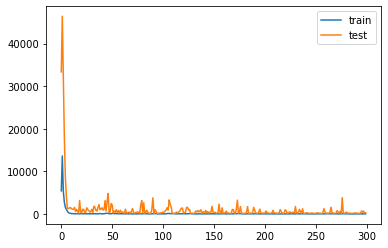

In [9]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [10]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

# convert the predicted value to range of real data
# y_pred_org = min_max_scaler_y.inverse_transform(y_pred.reshape(-1,1))
y_pred_org = y_pred.reshape(-1,1)
# min_max_scaler.inverse_transform(y_pred)
# y_test_t_org = min_max_scaler_y.inverse_transform(y_test_t.reshape(-1,1))
y_test_t_org =y_test_t.reshape(-1,1)
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org)
print(y_test_t_org)

Error is 2730.0618269132096 (420,) (420,)
[330.02036 357.27536 329.95676 364.68665 374.25916 378.64215 377.75854
 358.07095 368.41656 363.48752 362.9281  360.23953 373.26102 379.94232
 377.629  ]
[348.         365.20001221 380.         381.79998779 382.3999939
 376.6000061  380.20001221 374.3999939  379.79998779 376.3999939
 381.3999939  387.6000061  385.         391.3999939  395.        ]
[[330.02036]
 [357.27536]
 [329.95676]
 [364.68665]
 [374.25916]
 [378.64215]
 [377.75854]
 [358.07095]
 [368.41656]
 [363.48752]
 [362.9281 ]
 [360.23953]
 [373.26102]
 [379.94232]
 [377.629  ]
 [382.70877]
 [387.8472 ]
 [389.80988]
 [395.27402]
 [408.09064]
 [399.2195 ]
 [392.2847 ]
 [391.77628]
 [402.7455 ]
 [395.39035]
 [406.69733]
 [407.36313]
 [409.02158]
 [389.9237 ]
 [393.43204]
 [398.61594]
 [400.54526]
 [409.9326 ]
 [427.76996]
 [421.66882]
 [422.0811 ]
 [428.0555 ]
 [414.71997]
 [410.27493]
 [421.48154]
 [430.20468]
 [425.25333]
 [405.6929 ]
 [401.1675 ]
 [416.06024]
 [409.5035 ]
 [402.258

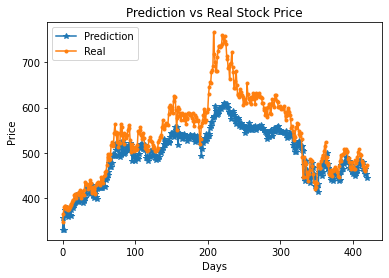

In [11]:
plt.figure()
plt.plot(y_pred_org,marker='*')
plt.plot(y_test_t_org,marker='.')
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')

In [12]:
r2_score(y_test_t_org,y_pred_org)

0.6297325324072707

In [13]:
y_pred_unseen=model.predict(x_unseen)
# y_pred_unseen=min_max_scaler_y.inverse_transform(y_pred_unseen)
# y_unseen=min_max_scaler_y.inverse_transform(y_unseen.reshape(-1,1))

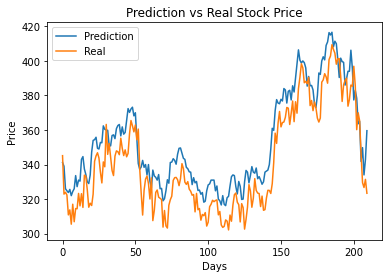

In [14]:
plt.figure()
plt.plot(y_unseen)
plt.plot(y_pred_unseen)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')

In [15]:
r2_score(y_unseen,y_pred_unseen)

0.7023965040073876

In [16]:
mean_squared_error(y_unseen,y_pred_unseen)

221.7393875937909

In [19]:
mean_absolute_percentage_error(y_unseen,y_pred_unseen)

0.03634043287673534

In [17]:
# model.save('HSBC-CNN&LSTM')